In [105]:
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import SimpleITK as sitk
import tensorflow as tf
import os
import numpy as np
from dltk.io.augmentation import flip
from dltk.io.preprocessing import whitening
from dltk.io.preprocessing import resize_image_with_crop_or_pad
from matplotlib import pyplot as plt
import nibabel as nib
import h5py
from scipy import ndimage
from sklearn.preprocessing import normalize
from skimage.measure import label
import cv2

# Binary Masks

Mask Shape: (202, 175, 175)


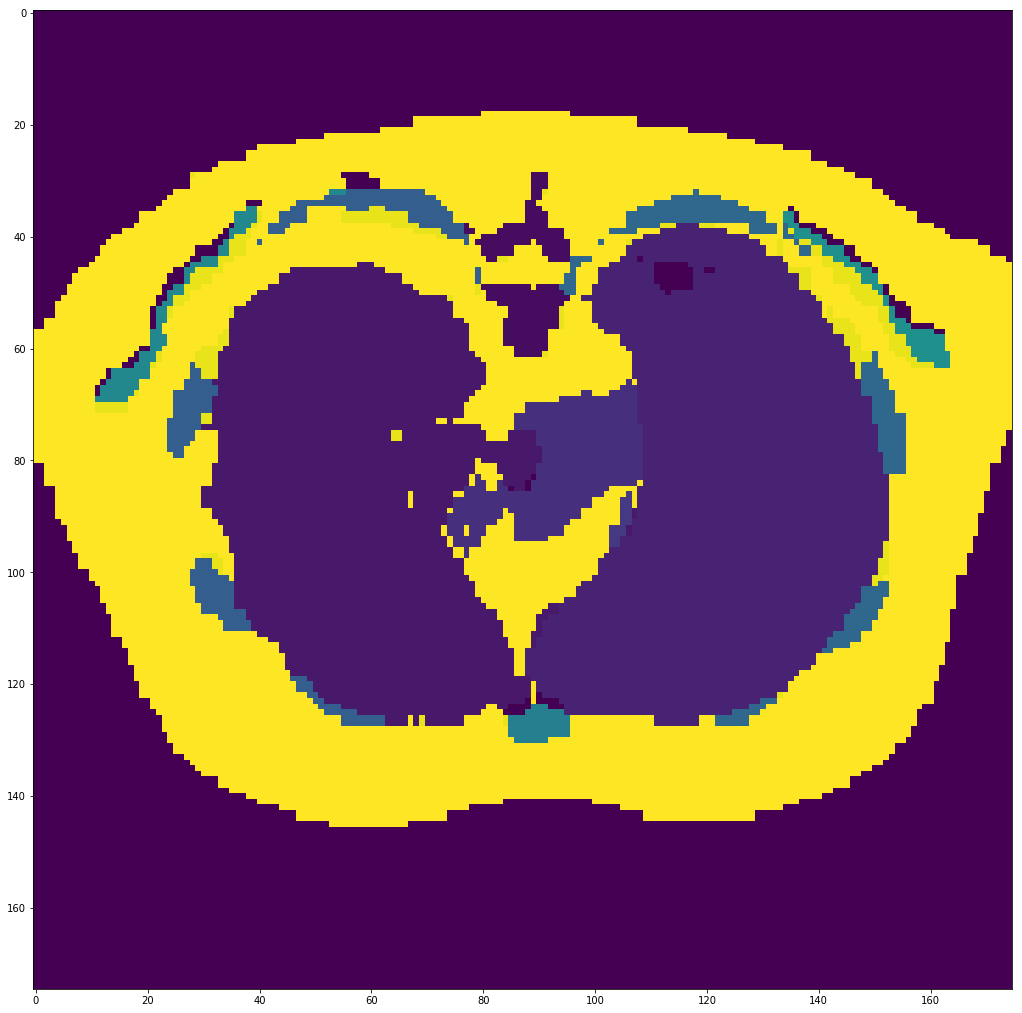

In [106]:
mask_path = './Diagram/window_seg_AARQ_838_2__niftynet_out.nii.gz'
mask      = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.int32)

slice = 139

plt.figure(figsize=[25,18])
print("Mask Shape:",mask.shape)
plt.imshow(mask[slice])
plt.show()

Mask Shape: (202, 175, 175)


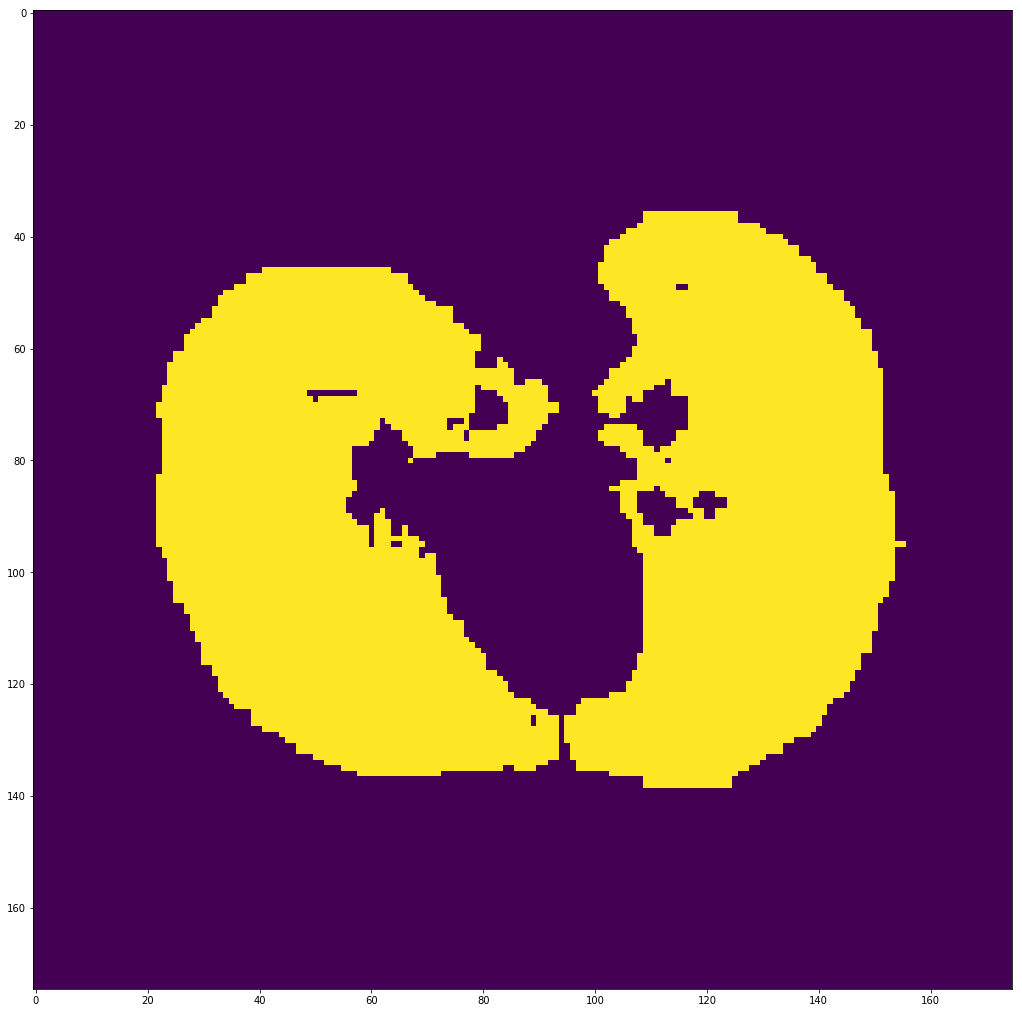

In [107]:
lungs_mask        = ((mask == 3)|(mask == 2)).astype(np.int32)

plt.figure(figsize=[25,18])     
print("Mask Shape:",lungs_mask.shape)
plt.imshow(lungs_mask[107])
plt.show()

Mask Shape: (202, 175, 175)


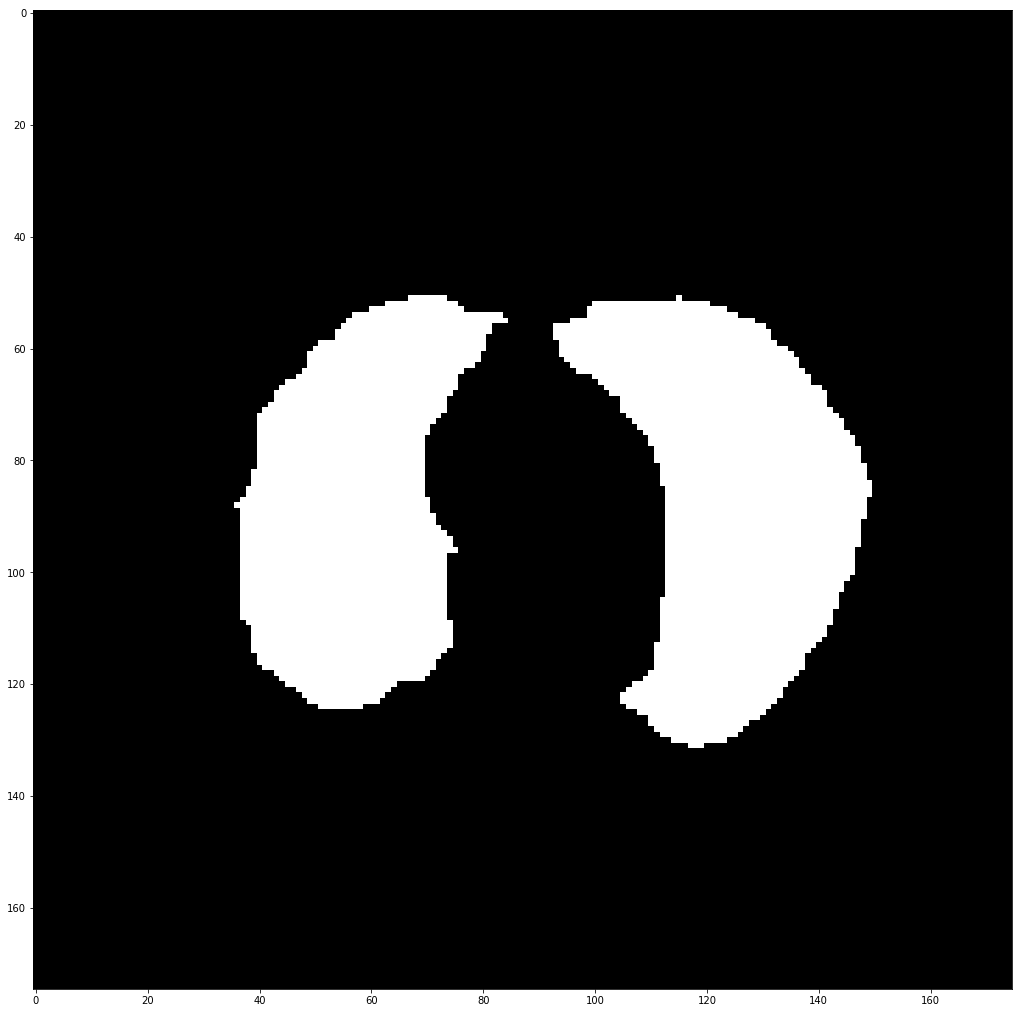

In [108]:
lungs_mask        = ((mask == 3)|(mask == 2)).astype(np.int32)

for i in range(0,lungs_mask.shape[0]):
    # Dilation
    lungs_mask[i,:,:] = ndimage.binary_dilation(lungs_mask[i,:,:]).astype(int)
    # Fill Holes
    lungs_mask[i,:,:] = ndimage.binary_fill_holes(lungs_mask[i,:,:], structure=np.ones((5,5))).astype(int)
    # Remove Side-Components
    label_im, nb_labels = ndimage.label(lungs_mask[i,:,:])
    sizes = ndimage.sum(lungs_mask[i,:,:], label_im, range(nb_labels + 1))
    temp_mask = sizes > 2500
    lungs_mask[i,:,:] = temp_mask[label_im]
    # Erosion
    lungs_mask[i,:,:] = ndimage.binary_erosion(lungs_mask[i,:,:], structure=np.ones((10,10))).astype(int)

plt.figure(figsize=[25,18])     
print("Mask Shape:",lungs_mask.shape)
plt.imshow(np.flip((lungs_mask[slice]),axis=0),cmap='gray')
plt.show()

In [109]:
peak = 0
for m in range(lungs_mask.shape[0]):
    if (img1[m].mean() <= -0.85):
        lungs_mask[m] = 0
    maxint = lungs_mask[m].sum()
    if (maxint>=peak):
        peak       = maxint
        peakslice  = m

    plt.figure(figsize=[25,18])     
print("Mask Shape:",lungs_mask.shape)
plt.imshow(lungs_mask[107])
plt.show()

NameError: name 'img1' is not defined

Mask Shape: (202, 175, 175)


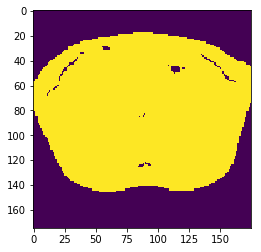

In [110]:
body_mask    = ((mask != 0)).astype(np.int32)


print("Mask Shape:",body_mask.shape)
plt.imshow(body_mask[slice])
plt.show()

Mask Shape: (202, 175, 175)


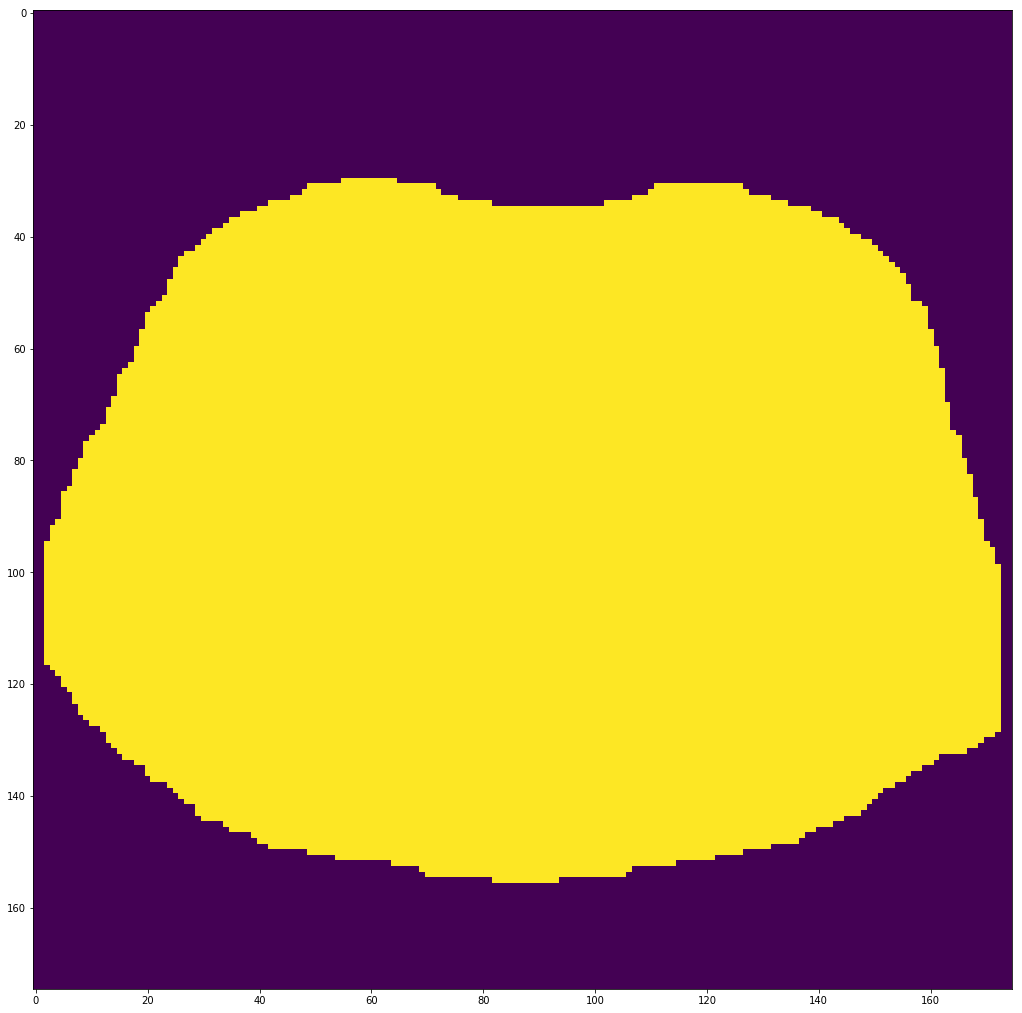

In [111]:
for i in range(0,body_mask.shape[0]):
    # Dilation
    body_mask[i,:,:] = ndimage.binary_dilation(body_mask[i,:,:]).astype(int)
    # Fill Holes
    body_mask[i,:,:] = ndimage.binary_fill_holes(body_mask[i,:,:], structure=np.ones((5,5))).astype(int)
    # Remove Side-Components
    label_im, nb_labels = ndimage.label(body_mask[i,:,:])
    sizes = ndimage.sum(body_mask[i,:,:], label_im, range(nb_labels + 1))
    temp_mask = sizes > 1000
    body_mask[i,:,:] = temp_mask[label_im]
    # Dilation
    body_mask[i,:,:] = ndimage.binary_erosion(body_mask[i,:,:], structure=np.ones((5,5))).astype(int)
    
    
plt.figure(figsize=[25,18])                                            
print("Mask Shape:",body_mask.shape)
plt.imshow(np.flip((body_mask[slice]),axis=0))
plt.show()


# Feature Maps

In [112]:
fm_path = './Diagram/NormFM_AGFN_4730_6.nii.gz'
file_reader = sitk.ImageFileReader()
file_reader = sitk.ImageFileReader()
file_reader.SetFileName(fm_path)
file_reader.ReadImageInformation()
feature_maps_size = list(file_reader.GetSize())
file_reader.SetExtractSize([0 if v == 1 else v for v in feature_maps_size])
feature_maps = file_reader.Execute()
feature_maps = sitk.Compose( [sitk.Extract(feature_maps, feature_maps.GetSize()[:3]+(0,), [0,0,0, i]) for i in range(feature_maps_size[-1])] )
feature_maps = sitk.GetArrayFromImage(feature_maps)

Feature Maps Shape: (308, 250, 250, 61)


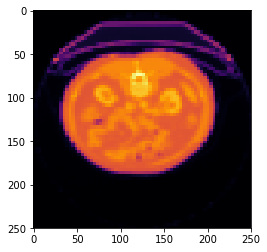

In [113]:
feature = 0

print("Feature Maps Shape:",feature_maps.shape)
plt.imshow(feature_maps[slice,:,:,feature], cmap='inferno')
plt.show()

Aggregated Feature Maps Shape: (308, 250, 250, 13)


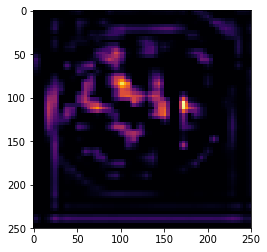

In [114]:
# Target Feature Components
aoo = np.expand_dims(feature_maps[:,:,:,3],axis=3)
boo = np.expand_dims(feature_maps[:,:,:,6],axis=3)
coo = np.expand_dims(feature_maps[:,:,:,8],axis=3)
doo = np.expand_dims(feature_maps[:,:,:,14],axis=3)
eoo = np.expand_dims(feature_maps[:,:,:,16],axis=3)    
foo = np.expand_dims(feature_maps[:,:,:,20],axis=3)
goo = np.expand_dims(feature_maps[:,:,:,22],axis=3)
hoo = np.expand_dims(feature_maps[:,:,:,25],axis=3)
ioo = np.expand_dims(feature_maps[:,:,:,35],axis=3)
joo = np.expand_dims(feature_maps[:,:,:,36],axis=3)
koo = np.expand_dims(feature_maps[:,:,:,47],axis=3)
loo = np.expand_dims(feature_maps[:,:,:,54],axis=3)
moo = np.expand_dims(feature_maps[:,:,:,55],axis=3)

aggregated_featuremaps  = np.concatenate((aoo,boo,coo,doo,eoo,foo,goo,hoo,ioo,joo,koo,loo,moo),axis=3)

print("Aggregated Feature Maps Shape:",aggregated_featuremaps.shape)
plt.imshow(aggregated_featuremaps[slice,:,:,3], cmap='inferno')
plt.show()

In [1079]:
# Target Feature Components
aoo = np.expand_dims(feature_maps[:,:,:,3]*body_mask,axis=3)
boo = np.expand_dims(feature_maps[:,:,:,6]*body_mask,axis=3)
coo = np.expand_dims(feature_maps[:,:,:,8]*body_mask,axis=3)
doo = np.expand_dims(feature_maps[:,:,:,14]*body_mask,axis=3)
eoo = np.expand_dims(feature_maps[:,:,:,16]*body_mask,axis=3)    
foo = np.expand_dims(feature_maps[:,:,:,20]*body_mask,axis=3)
goo = np.expand_dims(feature_maps[:,:,:,22]*body_mask,axis=3)
hoo = np.expand_dims(feature_maps[:,:,:,25]*body_mask,axis=3)
ioo = np.expand_dims(feature_maps[:,:,:,35]*body_mask,axis=3)
joo = np.expand_dims(feature_maps[:,:,:,36]*body_mask,axis=3)
koo = np.expand_dims(feature_maps[:,:,:,47]*body_mask,axis=3)
loo = np.expand_dims(feature_maps[:,:,:,54]*body_mask,axis=3)
moo = np.expand_dims(feature_maps[:,:,:,55]*body_mask,axis=3)

aggregated_featuremaps  = np.concatenate((aoo,boo,coo,doo,eoo,foo,goo,hoo,ioo,joo,koo,loo,moo),axis=3)

Aggregated Feature Maps Shape: (308, 250, 250, 13)


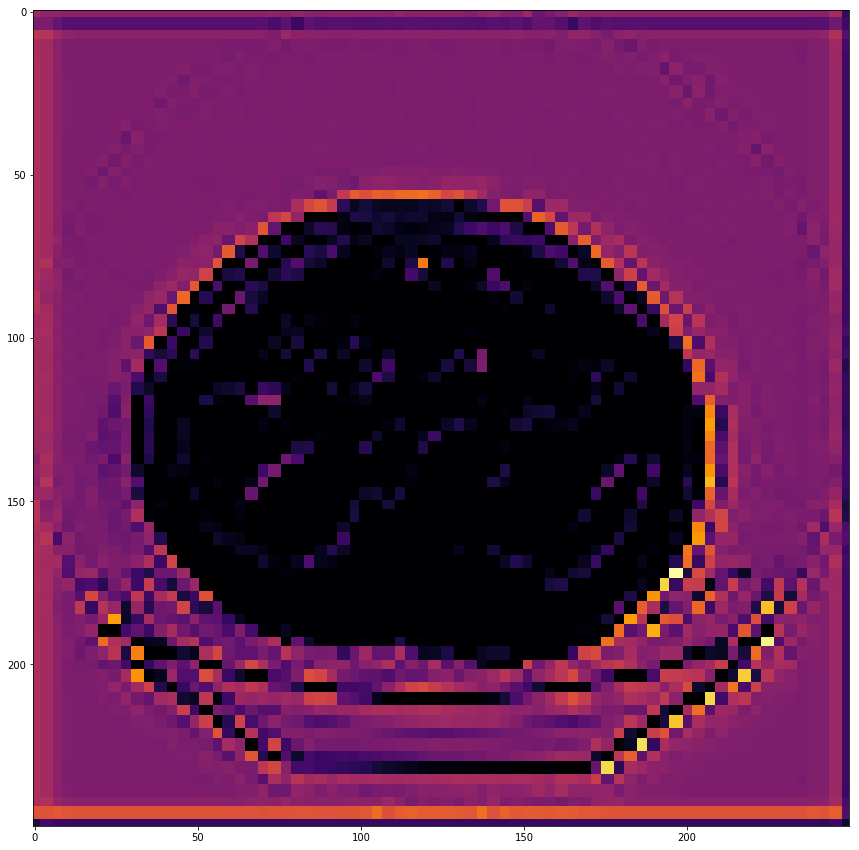

In [115]:
print("Aggregated Feature Maps Shape:",aggregated_featuremaps.shape)

plt.figure(figsize=[15,15])
plt.imshow(np.flip((aggregated_featuremaps[slice,:,:,2]),axis=0), cmap='inferno')
plt.show()

Aggregated Feature Maps Shape: (308, 250, 250)


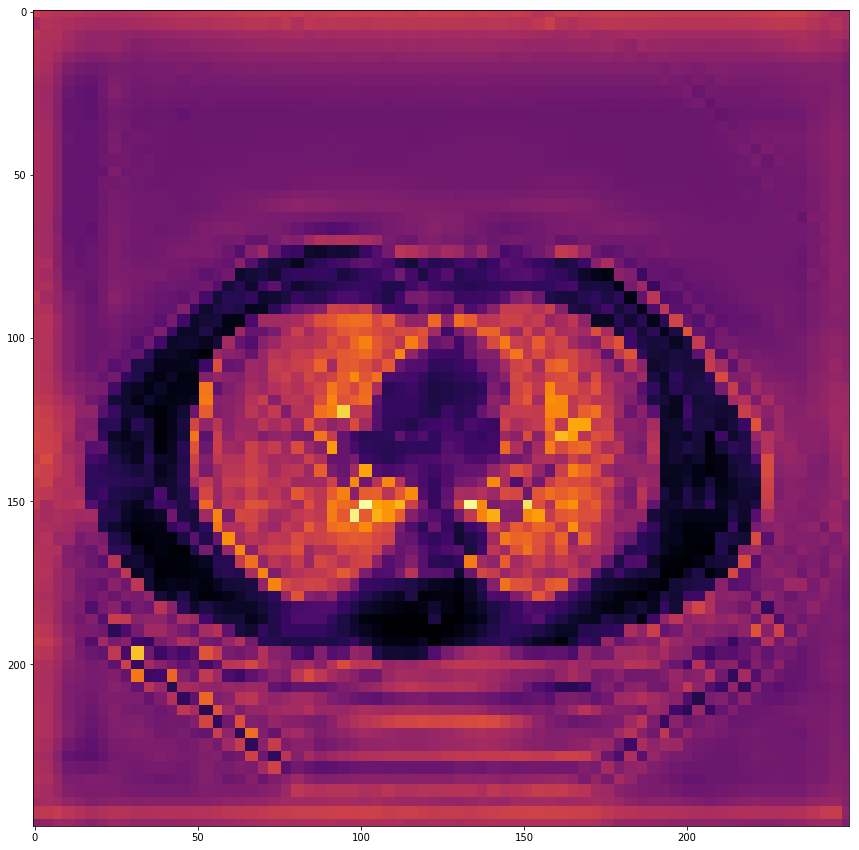

In [116]:
%matplotlib inline

experiment = np.mean(aggregated_featuremaps,axis=3)

plt.figure(figsize=[15,15])

print("Aggregated Feature Maps Shape:",experiment.shape)
plt.imshow(np.flip((experiment[239,:,:]),axis=0), cmap='inferno')
plt.show()

In [129]:
aggregated_featuremaps[:,:,:,1:13].shape

(308, 250, 250, 12)

## CT Slice

CT Shape: (244, 152, 195)


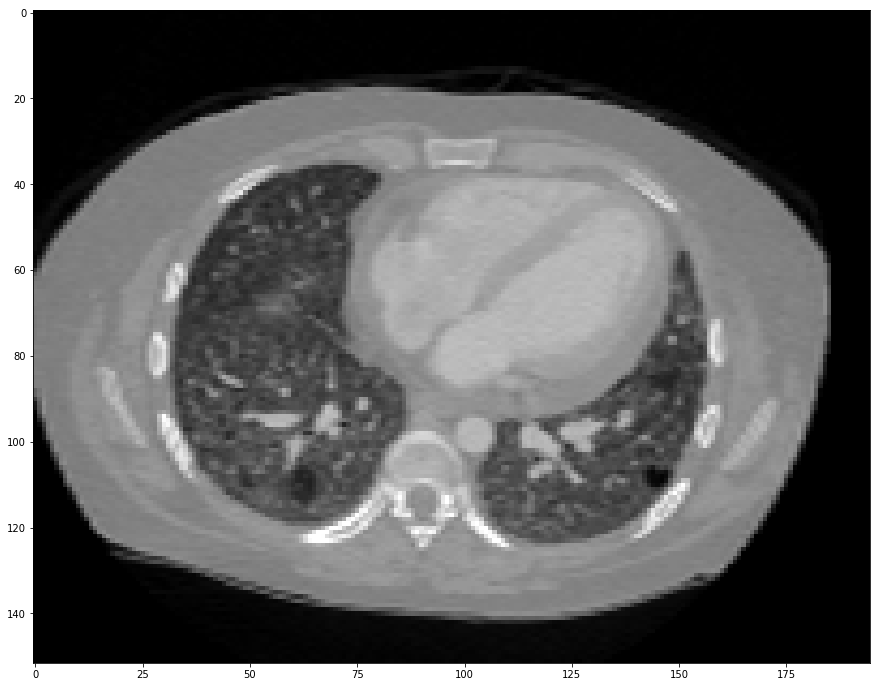

In [71]:
img_path = './CT_25420_7.nii.gz'
img      = sitk.GetArrayFromImage(sitk.ReadImage(img_path)).astype(np.float32)

slice = 227

plt.figure(figsize=[15,15])

print("CT Shape:",img.shape)
plt.imshow(np.flip((img[slice,:,:]),axis=0), cmap='gray')
plt.show()

In [1083]:
peakslice

239

In [1044]:
experiment[slice,113,131]

1.1099080810180078

In [15]:
hf.keys()

<KeysViewHDF5 ['ABOR_1058_8', 'AFPM_4233_6']>

In [16]:
hf = h5py.File('trainY.h5', 'r')
patch = hf.get('AFPM_4233_6')
patch.shape

(3, 112, 112, 112, 2)

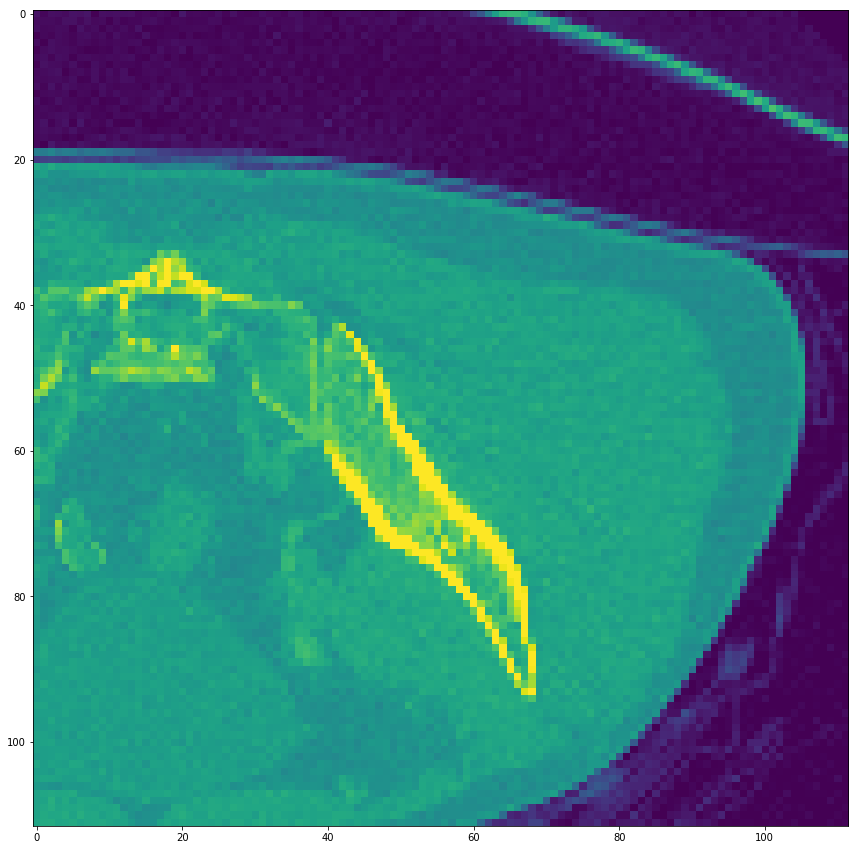

In [36]:
plt.figure(figsize=[15,15])
plt.imshow(patch[1,80,:,:,0])

In [72]:
img1 = whitening(img)

In [167]:
patch[0,100,56,56,0]

1.1531450748443604

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.eager import context
tf.enable_eager_execution()
print(tf.executing_eagerly())

def cyclic_learning_rate(global_step,
                         learning_rate=0.01,
                         max_lr=0.1,
                         step_size=20.,
                         gamma=0.99994,
                         mode='triangular',
                         name=None):
  """Applies cyclic learning rate (CLR).
     From the paper:
     Smith, Leslie N. "Cyclical learning
     rates for training neural networks." 2017.
     [https://arxiv.org/pdf/1506.01186.pdf]
      This method lets the learning rate cyclically
     vary between reasonable boundary values
     achieving improved classification accuracy and
     often in fewer iterations.
      This code varies the learning rate linearly between the
     minimum (learning_rate) and the maximum (max_lr).

      Polices:
        'triangular':
          Default, linearly increasing then linearly decreasing the
          learning rate at each cycle.
         'triangular2':
          The same as the triangular policy except the learning
          rate difference is cut in half at the end of each cycle.
          This means the learning rate difference drops after each cycle.
         'exp_range':
          The learning rate varies between the minimum and maximum
          boundaries and each boundary value declines by an exponential
          factor of: gamma^global_step.
  """
  if global_step is None:
    raise ValueError("global_step is required for cyclic_learning_rate.")
  with ops.name_scope(name, "CyclicLearningRate",
                      [learning_rate, global_step]) as name:
    learning_rate = ops.convert_to_tensor(learning_rate, name="learning_rate")
    dtype = learning_rate.dtype
    global_step = math_ops.cast(global_step, dtype)
    step_size = math_ops.cast(step_size, dtype)
    def cyclic_lr():

      double_step = math_ops.multiply(2., step_size)
      global_div_double_step = math_ops.divide(global_step, double_step)
      cycle = math_ops.floor(math_ops.add(1., global_div_double_step))

      double_cycle = math_ops.multiply(2., cycle)
      global_div_step = math_ops.divide(global_step, step_size)
      tmp = math_ops.subtract(global_div_step, double_cycle)
      x = math_ops.abs(math_ops.add(1., tmp))

      a1 = math_ops.maximum(0., math_ops.subtract(1., x))
      a2 = math_ops.subtract(max_lr, learning_rate)
      clr = math_ops.multiply(a1, a2)
      if mode == 'triangular2':
        clr = math_ops.divide(clr, math_ops.cast(math_ops.pow(2, math_ops.cast(
            cycle-1, tf.int32)), tf.float32))
      if mode == 'exp_range':
        clr = math_ops.multiply(math_ops.pow(gamma, global_step), clr)
      return math_ops.add(clr, learning_rate, name=name)
    if not context.executing_eagerly():
      cyclic_lr = cyclic_lr()
    return cyclic_lr

C:\Users\anindo-saha\Anaconda3\envs\tensorflow-RAI\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anindo-saha\Anaconda3\envs\tensorflow-RAI\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anindo-saha\Anaconda3\envs\tensorflow-RAI\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anindo-saha\Anacond

True


In [48]:
TRAIN_SIZE          =   1146
BATCH_SIZE          =   16
CLR_STEPSIZE        =   int(np.ceil((TRAIN_SIZE/BATCH_SIZE)*10))
CLR_MODE            =  'exp_range'
rates = []
step = 40000

for i in range(0, step):
    learning_rate       = cyclic_learning_rate(global_step=i, learning_rate=0.0000001, max_lr=0.001, step_size=CLR_STEPSIZE, gamma=0.9999, mode=CLR_MODE)
    rates.append(learning_rate())



In [49]:
%matplotlib qt
plt.xlabel('iterations (epochs)')
plt.ylabel('learning rate')
plt.plot(range(step), rates)

In [47]:
%matplotlib qt
plt.xlabel('iterations (epochs)')
plt.ylabel('learning rate')
plt.plot(range(step), rates)